### 🔧 Cell 0: Configure Import Paths

This cell appends the parent directory (`..`) to `sys.path` to ensure that shared modules such as `shared/` and `models/` can be imported seamlessly throughout the notebook. This is essential for accessing custom modules like `data_loader.py` or model definitions located outside the notebook's root directory.


In [1]:
# Cell 0: 모듈 import를 위한 경로 설정
import os, sys
sys.path.append(os.path.abspath(".."))  # shared, models 디렉토리 접근 가능하도록 경로 추가


### 🧪 Cell 1: Check PyTorch and GPU Environment

This cell verifies the current environment configuration:

- Prints the installed PyTorch version.
- Checks whether a CUDA-compatible GPU is available.
- If available, displays the GPU's name.

This ensures that the code will utilize GPU acceleration if supported by the system.


In [2]:
# Cell 1: 환경 확인
import torch

print(f"✅ PyTorch version: {torch.__version__}")
print(f"🚀 GPU available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"🧠 GPU name: {torch.cuda.get_device_name(0)}")
    
    total_memory = torch.cuda.get_device_properties(device).total_memory / 1024**3  # GiB
    reserved_memory = torch.cuda.memory_reserved(device) / 1024**3  # GiB
    allocated_memory = torch.cuda.memory_allocated(device) / 1024**3  # GiB
    free_memory = reserved_memory - allocated_memory  # GiB

    print(f"💾 Total memory: {total_memory:.2f} GiB")
    print(f"📦 Reserved memory: {reserved_memory:.2f} GiB")
    print(f"📈 Allocated memory: {allocated_memory:.2f} GiB")
    print(f"🟢 Free memory in reserved: {free_memory:.2f} GiB")


✅ PyTorch version: 2.6.0+cu124
🚀 GPU available: True
🧠 GPU name: Quadro RTX 5000
💾 Total memory: 15.73 GiB
📦 Reserved memory: 0.00 GiB
📈 Allocated memory: 0.00 GiB
🟢 Free memory in reserved: 0.00 GiB


### 📂 Cell 2: Load Dataset

This cell prepares the training dataset by:

- Importing the custom `HDF5Dataset` class for loading 3D subcube data from HDF5 files.
- Specifying the input and output directory paths containing `.h5` files.
- Creating sorted lists of input and target file paths.
- Initializing the dataset and wrapping it in a `DataLoader` with `batch_size=2` and shuffling enabled.
- Displaying the shape of a sample input-output pair to confirm successful data loading.

This step ensures that the model receives data in the correct format and structure.


In [3]:
# Cell 2: 데이터셋 로딩
from torch.utils.data import DataLoader
from shared.data_loader import HDF5Dataset
import os

input_dir = "/caefs/data/IllustrisTNG/subcube/input"
output_dir = "/caefs/data/IllustrisTNG/subcube/output"

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".h5")])
output_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".h5")])

dataset = HDF5Dataset(input_files, output_files)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

x, y = next(iter(loader))
print(f"✅ Sample loaded: input shape = {x.shape}, output shape = {y.shape}")


2025-07-31 19:41:18,872 | INFO | data_loader | 🔍 Initializing dataset with 12 file pairs.
2025-07-31 19:41:18,944 | INFO | data_loader | 📦 Total samples across all files: 110592


✅ Sample loaded: input shape = torch.Size([2, 1, 60, 60, 60]), output shape = torch.Size([2, 1, 60, 60, 60])


### 🧠 Cell 3: Initialize U-Net Model

This cell initializes the 3D U-Net model for training:

- Imports the custom `UNet3D` architecture from the project’s model directory.
- Detects whether a CUDA-compatible GPU is available and sets the appropriate device.
- Instantiates the model and moves it to the selected device.
- Sets the model to training mode using `model.train()`.

This prepares the neural network for forward and backward passes during training.


In [4]:
# Cell 3: U-Net 초기화
from models.unet.model import UNet3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D().to(device)
model.train()
print("✅ U-Net model loaded and set to training mode.")


✅ U-Net model loaded and set to training mode.


### 📊 Cell 4: Display U-Net Model Summary

This cell uses the `torchinfo` library to generate a detailed summary of the U-Net model:

- Provides the model with a dummy input tensor of shape `(2, 1, 60, 60, 60)` representing a batch of 2 subcubes.
- Displays information for each layer, including input/output shapes, number of parameters, and kernel sizes.

This summary helps verify the model architecture, parameter count, and compatibility with the input data.


In [5]:
from torchinfo import summary

summary(model, input_size=(2, 1, 60, 60, 60), col_names=["input_size", "output_size", "num_params", "kernel_size"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
UNet3D                                   [2, 1, 60, 60, 60]        [2, 1, 60, 60, 60]        --                        --
├─ConvBlockEnc: 1-1                      [2, 1, 60, 60, 60]        [2, 32, 30, 30, 30]       --                        --
│    └─ReplicationPad3d: 2-1             [2, 1, 60, 60, 60]        [2, 1, 64, 64, 64]        --                        --
│    └─Conv3d: 2-2                       [2, 1, 64, 64, 64]        [2, 32, 30, 30, 30]       4,032                     [5, 5, 5]
│    └─BatchNorm3d: 2-3                  [2, 32, 30, 30, 30]       [2, 32, 30, 30, 30]       64                        --
│    └─ReLU: 2-4                         [2, 32, 30, 30, 30]       [2, 32, 30, 30, 30]       --                        --
├─ConvBlockEnc: 1-2                      [2, 32, 30, 30, 30]       [2, 64, 15, 15, 15]       --                        --
│    └─

### ⚙️ Cell 5: Batch Size Compatibility Test

This cell defines and runs a function to test whether various batch sizes can be processed without running into memory or dimensional errors:

- Defines `test_batch_size(batch_size)` to:
  - Create a `DataLoader` with the specified batch size.
  - Instantiate and move the `UNet3D` model to the GPU.
  - Attempt a single forward pass with one batch.
- Catches and prints runtime errors (e.g., CUDA OOM or dimension mismatch).
- Iterates over a list of candidate batch sizes: `[32, 16, 8, 4, 2, 1]`.

This test helps determine the largest feasible batch size that can be used on the current GPU without errors.


In [6]:
def test_batch_size(batch_size):
    try:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        model = UNet3D().cuda()  # 사용 중인 모델로 교체
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            pred = model(x)
            print(f"✅ Success with batch_size={batch_size}")
            break  # 한 번만 테스트
    except RuntimeError as e:
        print(f"❌ Failed with batch_size={batch_size}: {str(e).splitlines()[0]}")

# 테스트할 batch size 리스트
for bs in [32, 16, 8, 4, 2, 1]:
    test_batch_size(bs)


✅ Success with batch_size=32
✅ Success with batch_size=16
✅ Success with batch_size=8
✅ Success with batch_size=4
✅ Success with batch_size=2
✅ Success with batch_size=1


### 🔍 Cell 4: Test Loss Functions

This cell verifies the implementation of loss functions used during training:

- Imports `mse_loss` and `spectral_loss` from the project's `shared.losses` module.
- Computes the Mean Squared Error (MSE) loss between a batch of input and target tensors.
- Prints the resulting loss value for confirmation.

This test ensures that the loss function operates correctly and is compatible with the loaded data format.


In [7]:
# Cell 4: 손실 함수 테스트
from shared.losses import mse_loss, spectral_loss

loss_val = mse_loss(x.to(device), y.to(device))
print(f"✅ MSE Loss on batch: {loss_val.item():.4f}")


✅ MSE Loss on batch: 35.2175


### 🧮 Cell 5: Set Optimizer and Learning Rate Scheduler

This cell initializes the optimization strategy for training:

- Uses the Adam optimizer with a learning rate of `1e-4` to update model parameters.
- Applies a cosine annealing learning rate scheduler (`CosineAnnealingLR`) with `T_max=10`, which gradually reduces the learning rate following a cosine curve over epochs.

These components help improve convergence and training stability.


In [8]:
# Cell 5: Optimizer 및 스케줄러 설정
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print("✅ Optimizer and LR scheduler initialized.")


✅ Optimizer and LR scheduler initialized.


In [9]:
# Cell 6: 빠른 학습 루프 (1 epoch, 일부 batch만)
from tqdm import tqdm

model.train()
n_batch = 10  # 테스트용으로 10개 배치만 학습

for epoch in range(3):
    total_loss = 0.0
    for i, (inputs, targets) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
        if i >= n_batch:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mse_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"📉 Epoch {epoch+1} (partial) Loss: {total_loss / n_batch:.4f}")
    print(f"📉 Epoch {epoch+1} (partial) Loss: {total_loss / n_batch:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")


Epoch 1:   0%|          | 10/55296 [00:02<4:01:45,  3.81it/s]


📉 Epoch 1 (partial) Loss: 0.5901
📉 Epoch 1 (partial) Loss: 0.5901 | LR: 9.76e-05


Epoch 2:   0%|          | 10/55296 [00:02<4:03:11,  3.79it/s]


📉 Epoch 2 (partial) Loss: 0.4829
📉 Epoch 2 (partial) Loss: 0.4829 | LR: 9.05e-05


Epoch 3:   0%|          | 10/55296 [00:02<3:29:47,  4.39it/s]


📉 Epoch 3 (partial) Loss: 0.4702
📉 Epoch 3 (partial) Loss: 0.4702 | LR: 7.94e-05


In [10]:
# Cell 7: 모델 저장
save_path = "unet3d_test_model.pt"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")


✅ Model saved to unet3d_test_model.pt


In [11]:
state_dict = torch.load("unet3d_test_model.pt", map_location='cpu')  # 또는 'cuda'
print(f"🔍 저장된 키 개수: {len(state_dict)}")
print("예시 키:", list(state_dict.keys())[:5])  # 일부 키만 출력


🔍 저장된 키 개수: 70
예시 키: ['enc1.conv.weight', 'enc1.conv.bias', 'enc1.bn.weight', 'enc1.bn.bias', 'enc1.bn.running_mean']


In [12]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    input_sample, target_sample = next(iter(loader))
    input_sample, target_sample = input_sample.to(device), target_sample.to(device)
    pred_sample = model(input_sample)




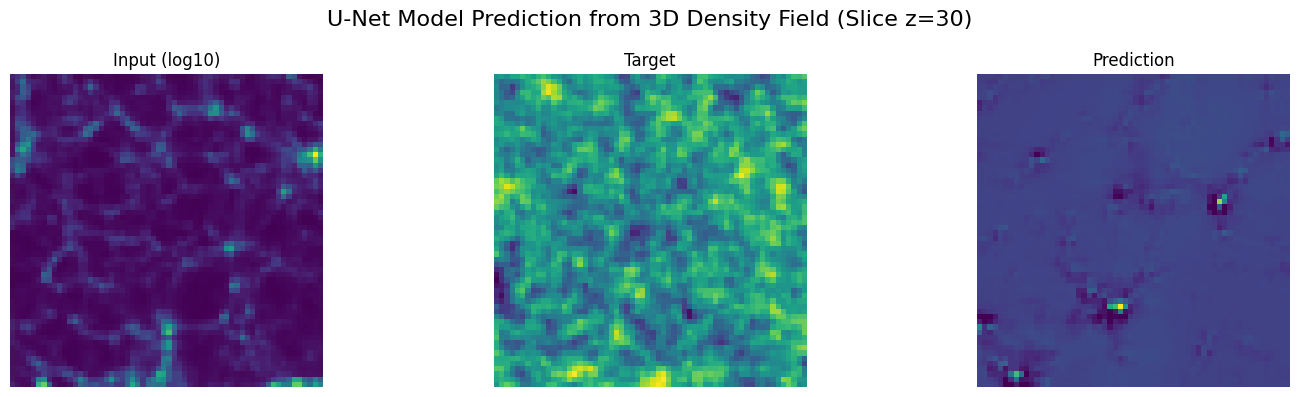

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 예시: input = [B, 1, D, H, W] 중에서 B=0, D=30인 2D 슬라이스
input_slice = inputs[0, 0, 30].detach().cpu().numpy()
target_slice = targets[0, 0, 30].detach().cpu().numpy()
pred_slice = outputs[0, 0, 30].detach().cpu().numpy()

# ✅ log-transform (0을 피하기 위해 log(1 + x) 사용)
input_log = np.log10(1 + input_slice)

# 📊 시각화
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(input_log, cmap='viridis')
axs[0].set_title('Input (log10)')

axs[1].imshow(target_slice, cmap='viridis')
axs[1].set_title('Target')

axs[2].imshow(pred_slice, cmap='viridis')
axs[2].set_title('Prediction')

for ax in axs:
    ax.axis('off')

plt.suptitle('U-Net Model Prediction from 3D Density Field (Slice z=30)', fontsize=16)  # ✅ 전체 제목 추가
plt.tight_layout()
plt.show()


In [15]:
import torch
from torchviz import make_dot

# 1. Prepare a dummy input with the correct shape. 
#    Example for a 3D U-Net with input shape [B, C, D, H, W]:
dummy_input = torch.randn(1, 1, 64, 64, 64, requires_grad=False, device=next(model.parameters()).device)

# 2. Forward pass through the U-Net
output = model(dummy_input)  # shape might be [1, 1, 64, 64, 64] or similar

# 3. Reduce to a scalar to avoid graph ambiguity (optional but recommended for large outputs)
scalar_output = output.mean()

# 4. Create the graph
dot = make_dot(scalar_output, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

# 5. Render to file
dot.format = "png"
dot.render("unet_structure", cleanup=True)  # produces unet_structure.png


'unet_structure.png'

In [16]:
import torch
from torchviz import make_dot

dummy_input = torch.randn(1, 1, 60, 60, 60, device=next(model.parameters()).device)

# trace the model (this gives a ScriptModule with a fixed graph)
traced = torch.jit.trace(model, dummy_input)

# get output and reduce
out = traced(dummy_input)
scalar = out.mean()

# visualize
dot = make_dot(scalar, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
dot.format = "pdf"  # 또는 png
dot.render("unet_traced_summary", cleanup=True)


/caefs/user/mmingyeong/_dm2ics_model_benchmark/dm2ics_model_benchmark/models/unet/model.py:68: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[2:] != skip.shape[2:]:


'unet_traced_summary.pdf'

In [18]:
from graphviz import Digraph

g = Digraph()
g.node("In", "Input [1,1,60³]")
g.node("E1", "EncBlock1\n32ch\n↓2")
g.node("E2", "EncBlock2\n64ch\n↓2")
g.node("E3", "EncBlock3\n128ch\n↓2")
g.node("E4", "EncBlock4\n256ch\n↓2")
g.node("B", "Bottleneck\n512ch")
g.node("D1", "DecBlock1\n256ch\n↑2")
g.node("D2", "DecBlock2\n128ch\n↑2")
g.node("D3", "DecBlock3\n64ch\n↑2")
g.node("D4", "DecBlock4\n32ch\n↑2")
g.node("Out", "Output [1,1,60³]")

# connections with skip
g.edge("In", "E1")
g.edge("E1", "E2")
g.edge("E2", "E3")
g.edge("E3", "E4")
g.edge("E4", "B")
g.edge("B", "D1")
g.edge("E4", "D1", style="dashed", label="skip")
g.edge("D1", "D2")
g.edge("E3", "D2", style="dashed", label="skip")
g.edge("D2", "D3")
g.edge("E2", "D3", style="dashed", label="skip")
g.edge("D3", "D4")
g.edge("E1", "D4", style="dashed", label="skip")
g.edge("D4", "Out")

g.render("unet_module_schematic", format="png", cleanup=True)


'unet_module_schematic.png'